# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.3


In [2]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [39]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [40]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


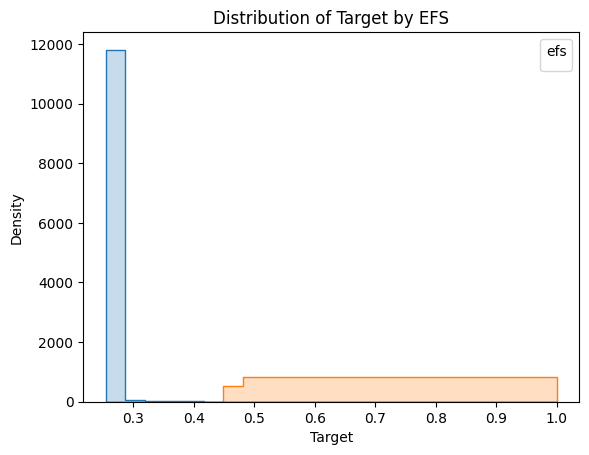

In [41]:
train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2 # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= 0.2 # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= 0.2 # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

In [42]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [43]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [44]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [49]:
test.columns
# test_balanced.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [50]:
train.head()

ID        dri_score psych_disturb    cyto_score diabetes  \
0  16167     Intermediate            No           NAN       No   
1   3266  N/A - pediatric            No          Poor      Yes   
2  21307              Low           NAN           TBD      NAN   
3   7246     Intermediate           Yes           NAN       No   
4   3810     Intermediate           Yes  Intermediate      Yes   

   hla_match_c_high  hla_high_res_8         tbi_status arrhythmia  \
0               NaN             NaN             No TBI         No   
1               1.0             4.0  TBI + Cy +- Other         No   
2               2.0             6.0  TBI + Cy +- Other        NAN   
3               1.0             4.0  TBI + Cy +- Other         No   
4               NaN             NaN             No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_issue pulm_severe  \
0            NaN       Bone marrow        No          No          No   
1            3.0  Peripheral blood        No          No          No   
2            6.0  Peripheral blood        No         NAN          No   
3            3.0  Peripheral blood        No          No          No   
4            6.0  Peripheral blood        No          No          No   

  prim_disease_hct  hla_high_res_6 cmv_status  hla_high_res_10  \
0              AML             NaN        NAN              NaN   
1              ALL             3.0        +/+              5.0   
2              AML             4.0        -/+              7.0   
3               AI             3.0        +/-              5.0   
4              AML             NaN        +/+              NaN   

   hla_match_dqb1_high tce_imm_match  hla_nmdp_6  hla_match_c_low rituximab  \
0                  NaN           NAN         NaN              NaN        No   
1                  1.0           NAN         3.0              1.0        No   
2                  1.0           NAN         4.0              1.0       NAN   
3                  1.0           P/P         3.0              1.0        No   
4                  NaN           NAN         NaN              2.0        No   

   hla_match_drb1_low  hla_match_dqb1_low prod_type cyto_score_detail  \
0                 NaN                 NaN        BM               NAN   
1                 1.0                 1.0        PB              Poor   
2                 2.0                 NaN        PB              Poor   
3                 1.0                 1.0        PB               NAN   
4                 2.0                 2.0        PB      Intermediate   

  conditioning_intensity               ethnicity  year_hct   obesity  \
0                    MAC  Not Hispanic or Latino      2009        No   
1                    MAC      Hispanic or Latino      2019  Not done   
2                    MAC  Not Hispanic or Latino      2017       NAN   
3                    MAC  Not Hispanic or Latino      2018        No   
4                    MAC                     NAN      2018        No   

    mrd_hct in_vivo_tcd tce_match  hla_match_a_high hepatic_severe  donor_age  \
0  Negative         Yes       NAN               NaN             No  41.931999   
1       NAN          No       NAN               1.0             No  26.260000   
2       NAN         Yes       NAN               2.0             No  25.659000   
3  Negative          No       NAN               1.0             No  34.078999   
4  Negative          No       NAN               NaN             No  62.641998   

  prior_tumor  hla_match_b_low peptic_ulcer  age_at_hct  hla_match_a_low  \
0          No              NaN           No   15.262000              NaN   
1          No              1.0           No   24.122999              1.0   
2         NAN              2.0          NAN   37.915001              2.0   
3          No              1.0           No   29.034000              1.0   
4          No              2.0           No   18.614000              2.0   

               gvhd_proph rheum_issue sex_match  hla_match_b_high  \
0   

In [51]:
test.head()

ID                                  dri_score psych_disturb  \
0  21239                           TBD cytogenetics            No   
1  22997  High - TED AML case <missing cytogenetics           Yes   
2  14885  High - TED AML case <missing cytogenetics            No   
3  13372             N/A - disease not classifiable            No   
4  12814                                       High            No   

     cyto_score diabetes  hla_match_c_high  hla_high_res_8         tbi_status  \
0          Poor       No               2.0             8.0             No TBI   
1  Intermediate       No               2.0             8.0  TBI + Cy +- Other   
2          Poor       No               NaN             NaN  TBI + Cy +- Other   
3          Poor       No               1.0             4.0  TBI + Cy +- Other   
4           NAN       No               1.0             5.0             No TBI   

  arrhythmia  hla_low_res_6        graft_type vent_hist renal_issue  \
0         No            6.0       Bone marrow        No          No   
1         No            6.0  Peripheral blood        No          No   
2        NAN            5.0  Peripheral blood        No         NAN   
3         No            3.0  Peripheral blood        No          No   
4         No            3.0  Peripheral blood        No          No   

  pulm_severe prim_disease_hct  hla_high_res_6 cmv_status  hla_high_res_10  \
0          No              ALL             6.0        -/+             10.0   
1          No              AML             6.0        -/+             10.0   
2          No              AML             6.0        -/-              NaN   
3          No              MDS             3.0        +/+              5.0   
4          No              IIS             4.0        +/+              NaN   

   hla_match_dqb1_high tce_imm_match  hla_nmdp_6  hla_match_c_low rituximab  \
0                  2.0           H/H         6.0              2.0        No   
1                  2.0           P/P         4.0              2.0        No   
2                  NaN           NAN         6.0              NaN        No   
3                  1.0           NAN         3.0              1.0        No   
4                  NaN           NAN         3.0              1.0        No   

   hla_match_drb1_low  hla_match_dqb1_low prod_type cyto_score_detail  \
0                 2.0                 2.0        BM      Intermediate   
1                 2.0                 2.0        PB      Intermediate   
2                 2.0                 NaN        PB               NAN   
3                 1.0                 1.0        PB              Poor   
4                 1.0                 NaN        PB               NAN   

  conditioning_intensity               ethnicity  year_hct obesity   mrd_hct  \
0                    MAC  Not Hispanic or Latino      2014      No       NAN   
1                    NMA  Not Hispanic or Latino      2015      No  Positive   
2                    RIC  Not Hispanic or Latino      2013      No       NAN   
3                    NMA  Not Hispanic or Latino      2016      No       NAN   
4                    MAC  Not Hispanic or Latino      2018      No       NAN   

  in_vivo_tcd tce_match  hla_match_a_high hepatic_severe  donor_age  \
0         Yes       NAN               2.0             No  36.930000   
1          No       NAN               2.0             No  64.930000   
2          No       NAN               2.0             No  40.089001   
3          No       NAN               1.0             No  68.125000   
4         Yes       NAN               2.0             No  50.873001   

  prior_tumor  hla_match_b_low peptic_ulcer  age_at_hct  hla_match_a_low  \
0          No              2.0           No   37.487000              2.0   
1          No              2.0           No   55.539001              2.0   
2          No              2.0           No   69.181999              1.0   
3          No              1.0           No   63.762001              1.0   
4     

In [52]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [53]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# XGBoost

In [15]:
%%time

oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame()
feature_importances_xgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    # define two extra dataframe for the custom metric
    ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
    
    clf = XGBRegressor(
        tree_method="hist",
        max_depth=3,
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10000,  
        learning_rate=0.03,
        early_stopping_rounds=100,
        objective='reg:squarederror',
        enable_categorical=True,
        min_child_weight=5,
        eval_metric=CIndexMetric_XGB, # the custom metric
        disable_default_eval_metric=True # only show the custom metric
    )
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500,
    )
    feature_importances_xgb[f'fold_{fold + 1}'] = feature_importances_xgb['feature'].map(clf.get_booster().get_score())

    preds_valid = clf.predict(x_valid)
    oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid

    # don't use joblib or pickle to save the model(Cannot load it)
    clf.save_model(f"xgb_model_{fold}.bin")

    y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

[0]	validation_0-CIndexMetric_XGB:-0.60378
[500]	validation_0-CIndexMetric_XGB:-0.66565
[1000]	validation_0-CIndexMetric_XGB:-0.67325
[1463]	validation_0-CIndexMetric_XGB:-0.67453
# c-index=0.6749, mean=0.6881 std=0.0132
[0]	validation_0-CIndexMetric_XGB:-0.60184
[500]	validation_0-CIndexMetric_XGB:-0.66912
[1000]	validation_0-CIndexMetric_XGB:-0.67427
[1500]	validation_0-CIndexMetric_XGB:-0.67616
[1831]	validation_0-CIndexMetric_XGB:-0.67620
# c-index=0.6763, mean=0.6923 std=0.0160
[0]	validation_0-CIndexMetric_XGB:-0.60997
[500]	validation_0-CIndexMetric_XGB:-0.67521
[1000]	validation_0-CIndexMetric_XGB:-0.67901
[1286]	validation_0-CIndexMetric_XGB:-0.67947
# c-index=0.6795, mean=0.6856 std=0.0060
[0]	validation_0-CIndexMetric_XGB:-0.59969
[500]	validation_0-CIndexMetric_XGB:-0.66407
[1000]	validation_0-CIndexMetric_XGB:-0.66828
[1500]	validation_0-CIndexMetric_XGB:-0.67008
[1656]	validation_0-CIndexMetric_XGB:-0.67027
# c-index=0.6705, mean=0.6827 std=0.0123
[0]	validation_0-CIndexM

In [85]:

def evaluate_test_set(test_set, model_prefix, skf, FEATURES, custom_score, dataset_name="test set"):
    """
    Evaluate the model on a given test set (imbalanced or balanced).
    
    Parameters:
        test_set (pd.DataFrame): The test set to evaluate.
        model_prefix (str): Prefix for the saved model filenames.
        skf (StratifiedKFold): Cross-validation object to determine the number of folds.
        FEATURES (list): List of feature columns.
        custom_score (function): Function to compute custom evaluation metric.
        dataset_name (str): Name of the dataset for logging purposes.
    
    Returns:
        None (prints evaluation results)
    """
    print(f"Evaluating on {dataset_name}...")

    # Ensure the test set has the required feature columns
    if not set(FEATURES).issubset(test_set.columns):
        raise ValueError(f"{dataset_name} does not have all required feature columns.")

    # Initialize an array to accumulate predictions from each fold
    test_predictions = np.zeros(len(test_set))

    # Initialize a dictionary to store the evaluation metric for each fold
    metric_df = []

    # Loop over folds, load each saved model, and predict on the test set
    for fold in range(skf.n_splits):
        model_filename = f"xgb/{model_prefix}_{fold}.bin"
        clf = XGBRegressor()  # We only use this to load the saved booster
        clf.load_model(model_filename)
        fold_pred = clf.predict(test_set[FEATURES])
        test_set[f'prediction_{fold}'] = fold_pred

        # If labels exist, compute the custom metric for this fold
        if "label" in test_set.columns:
            y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
            y_pred_test = test_set[["ID", f"prediction_{fold}"]].copy().reset_index(drop=True)
            m, metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label=f"prediction_{fold}")
            print(f"{dataset_name} evaluation metric for fold {fold}:", metric_dict)
            metric_df.append(metric_dict)

        test_predictions += fold_pred

    # Average the predictions across folds
    test_predictions /= skf.n_splits
    test_set['ensemble_prediction'] = test_predictions

    print('\nENSEMBLE:')
    # If labels exist, compute the custom metric for an ensemble
    if "label" in test_set.columns:
        y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
        y_pred_test = test_set[["ID", "ensemble_prediction"]].copy().reset_index(drop=True)
        m, ensemble_metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label="ensemble_prediction")
        print(f"{dataset_name} evaluation metric:", metric_dict)
    else:
        print(f"{dataset_name} predictions computed. No labels available for evaluation.")
    return ensemble_metric_dict, metric_df


# Evaluation on full test set

In [86]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, "xgb_model", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6553, mean=0.6685 std=0.0132
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6891962778816768, 'Asian': 0.6758678188762577, 'Black or African-American': 0.6544404424458132, 'More than one race': 0.6598799753914729, 'Native Hawaiian or other Pacific Islander': 0.6541397533763946, 'White': 0.6775691738497265}
# c-index=0.6535, mean=0.6701 std=0.0166
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6976805181772567, 'Asian': 0.6799013035591559, 'Black or African-American': 0.6554634385456406, 'More than one race': 0.665416893986001, 'Native Hawaiian or other Pacific Islander': 0.6469091453375243, 'White': 0.6754240957216515}
# c-index=0.6574, mean=0.6699 std=0.0125
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6889054873876751, 'Asian': 0.6719920682312381, 'Black or African-American': 0.6530231665991774, 'More than one race': 

In [87]:
display_overall(pd.DataFrame(balanced_metric_dicts))

In [81]:
test_balanced['race_group'].value_counts(normalize=True)

race_group
More than one race                           0.168056
Asian                                        0.167708
White                                        0.167708
Black or African-American                    0.166667
American Indian or Alaska Native             0.166319
Native Hawaiian or other Pacific Islander    0.163542
Name: proportion, dtype: float64

# Evaluation on imbalanced test subset

In [88]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, "xgb_model", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5811, mean=0.6395 std=0.0584
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6839430894308943, 'Asian': 0.6629418472063854, 'Black or African-American': 0.6386241040419715, 'More than one race': 0.5129819040125885, 'Native Hawaiian or other Pacific Islander': 0.6609538002980626, 'White': 0.6775691738497265}
# c-index=0.5798, mean=0.6375 std=0.0577
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6856368563685636, 'Asian': 0.6633979475484607, 'Black or African-American': 0.6342643907485406, 'More than one race': 0.5137686860739575, 'Native Hawaiian or other Pacific Islander': 0.6527570789865872, 'White': 0.6754240957216515}
# c-index=0.5780, mean=0.6407 std=0.0627
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6866531165311653, 'Asian': 0.6519954389965793, 'Black or African-American': 0.6419493090962831, 'More than on

In [79]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

In [83]:
test['race_group'].value_counts(normalize=True)

(2880, 68)

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_xgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_xgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
feature_importances_xgb['importance'] = feature_importances_xgb.drop('feature', axis=1).mean(axis=1)
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances_xgb.head(20)

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")